# Data Augmentation And Image Pipelines

* Real Life Datasets can be large or small
* Image Pipelines are an efficient way to handle large datasets
* Data Augmentation is technique of augmenting data, which acts as a regularizer hence reduces overfitting

In [7]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
train_image_gen = ImageDataGenerator(rescale=1.0/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.3,horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1.0/255)

In [4]:
train_gen = train_image_gen.flow_from_directory("tiny-imagenet-200/train",target_size=((224,224)),batch_size=128,class_mode='categorical')

Found 100000 images belonging to 200 classes.


In [6]:
print(train_gen.class_indices)

{'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53, 'n02480495': 54, 'n02481823': 55, 'n02486410': 56, 'n02504458': 57, 'n02509815': 58, 'n0266

(128, 224, 224, 3) (128, 200)


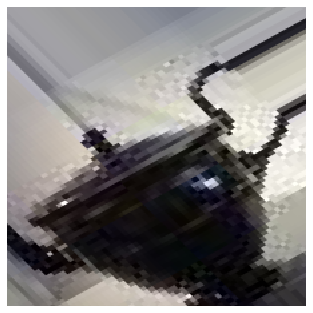

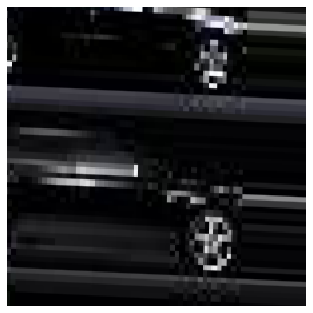

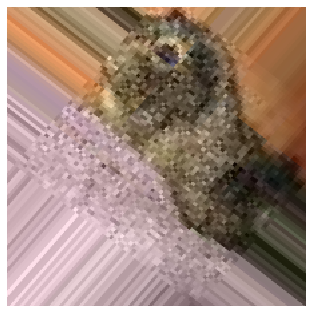

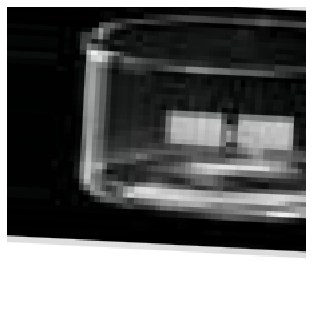

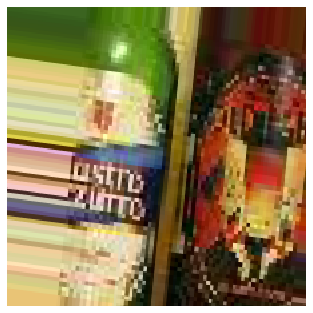

In [9]:
for (X,y) in train_gen:
    print(X.shape,y.shape)
    for i in range(5):
        plt.imshow(X[i])
        plt.axis('off')
        plt.show()
    break